This notebook walks through the preprocessing/QA workflow described in the course slides.

Importing modules

In [1]:
import os, errno
try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'
print 'Using data from',datadir

%matplotlib inline

from nipype.interfaces import fsl, nipy
import nibabel
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from compute_fd_dvars import compute_fd,compute_dvars
from nipype.caching import Memory
mem = Memory(base_dir='.')
results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    
def force_symlink(file1, file2):
    try:
        os.symlink(file1, file2)
    except OSError, e:
        if e.errno == errno.EEXIST:
            os.remove(file2)
            os.symlink(file1, file2)

Using data from /home/vagrant/data


Setting up variables

In [2]:
subject='ses014'  

bolddir=os.path.join(datadir,'ds031/sub00001',subject,
        'functional')
boldfile=os.path.join(bolddir,'sub00001_ses014_task002_run001_bold.nii.gz')


## Motion correction using MCFLIRT

This will take about a minute.

In [3]:
mcflirt = mem.cache(fsl.MCFLIRT)
mcflirt_results = mcflirt(in_file=boldfile,
                          save_plots=True,
                          mean_vol=True)
mcflirt_results.outputs

INFO:workflow:Executing node a06d2fe43fd8d45183f86c7f607ad25c in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/a06d2fe43fd8d45183f86c7f607ad25c
INFO:workflow:Collecting precomputed outputs



mat_file = <undefined>
mean_img = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/a06d2fe43fd8d45183f86c7f607ad25c/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg.nii.gz
out_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/a06d2fe43fd8d45183f86c7f607ad25c/sub00001_ses014_task002_run001_bold_mcf.nii.gz
par_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/a06d2fe43fd8d45183f86c7f607ad25c/sub00001_ses014_task002_run001_bold_mcf.nii.gz.par
rms_files = <undefined>
std_img = <undefined>
variance_img = <undefined>

In [4]:
fsl.MCFLIRT.help()

Wraps command **mcflirt**

Use FSL MCFLIRT to do within-modality motion correction.

For complete details, see the `MCFLIRT Documentation.
<http://www.fmrib.ox.ac.uk/fsl/mcflirt/index.html>`_

Examples
--------
>>> from nipype.interfaces import fsl
>>> from nipype.testing import example_data
>>> mcflt = fsl.MCFLIRT(in_file=example_data('functional.nii'), cost='mutualinfo')
>>> res = mcflt.run() # doctest: +SKIP

Inputs::

	[Mandatory]
	in_file: (an existing file name)
		timeseries to motion-correct
		flag: -in %s, position: 0

	[Optional]
	args: (a string)
		Additional parameters to the command
		flag: %s
	bins: (an integer (int or long))
		number of histogram bins
		flag: -bins %d
	cost: ('mutualinfo' or 'woods' or 'corratio' or 'normcorr' or
		 'normmi' or 'leastsquares')
		cost function to optimize
		flag: -cost %s
	dof: (an integer (int or long))
		degrees of freedom for the transformation
		flag: -dof %d
	environ: (a dictionary with keys which are a value of type 'str' and
		 with

We will need the mean EPI image later during the class so we will save it.

In [5]:
force_symlink(mcflirt_results.outputs.mean_img, os.path.join(results_dir, "meanbold.nii.gz"))

Use FSL's BET to obtain the brain mask

In [6]:
bet = mem.cache(fsl.BET)
bet_results = bet(functional=True,
              in_file=mcflirt_results.outputs.mean_img,
              mask=True)
force_symlink(bet_results.outputs.mask_file, os.path.join(results_dir, "mask.nii.gz"))
bet_results.outputs

INFO:workflow:Executing node f219b0aeaddfc6cf0539f6f7ac2978b9 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/f219b0aeaddfc6cf0539f6f7ac2978b9
INFO:workflow:Collecting precomputed outputs



inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/f219b0aeaddfc6cf0539f6f7ac2978b9/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_brain_mask.nii.gz
meshfile = <undefined>
out_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/f219b0aeaddfc6cf0539f6f7ac2978b9/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>

Display the mean image, and show the outline of the brain mask.

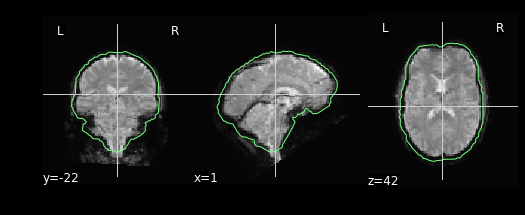

In [7]:
mask_display=nilearn.plotting.plot_epi(mcflirt_results.outputs.mean_img,cmap='gray')
mask_display.add_contours(bet_results.outputs.mask_file, levels=[.5])

Compute and plot the global signal within the mask across timepoints

In [8]:
maskdata=nibabel.load(bet_results.outputs.mask_file).get_data()
bolddata=nibabel.load(mcflirt_results.outputs.out_file).get_data()
maskvox=numpy.where(maskdata)
globalmean=numpy.zeros(bolddata.shape[3])
globalcv=numpy.zeros(bolddata.shape[3])
for t in range(bolddata.shape[3]):
    tmp=bolddata[:,:,:,t]
    globalmean[t]=numpy.mean(tmp[maskvox])
    globalcv[t]=numpy.std(tmp[maskvox])/numpy.mean(tmp[maskvox])

del bolddata


Load motion data and compute FD/DVARS

In [23]:
motiondata=numpy.loadtxt(mcflirt_results.outputs.par_file)

fd=compute_fd(motiondata)
dvars=compute_dvars(globalmean)
motiondata.shape

(190, 6)

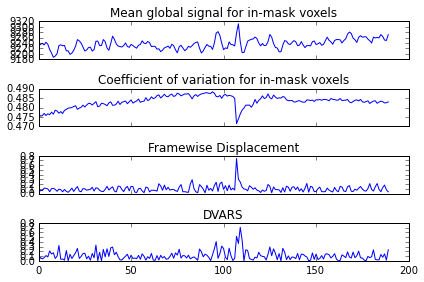

In [10]:
f, (ax1, ax2,ax3,ax4)=plt.subplots(4, sharex=True)
ax1.plot(globalmean)
ax1.set_title('Mean global signal for in-mask voxels')

ax2.plot(globalcv)
ax2.set_title('Coefficient of variation for in-mask voxels')

ax3.plot(fd)
ax3.set_title('Framewise Displacement')

ax4.plot(dvars)
ax4.set_title('DVARS')
plt.tight_layout()

## Performing Independent Component Analysis to look for artefacts

Run independent components analysis on the data using MELODIC - this will take a few minutes.

In [11]:
melodic = mem.cache(fsl.MELODIC)
melodic_results = melodic(out_all=True,
                          report=True,
                          in_files=mcflirt_results.outputs.out_file,
                          mask=bet_results.outputs.mask_file)
melodic_results.outputs

INFO:workflow:Executing node 9b3408bed171054348e9dd1133991505 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-model-MELODIC/9b3408bed171054348e9dd1133991505
INFO:workflow:Collecting precomputed outputs



out_dir = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-model-MELODIC/9b3408bed171054348e9dd1133991505
report_dir = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-model-MELODIC/9b3408bed171054348e9dd1133991505/report

Check out the MELODIC report

In [24]:
from IPython.display import FileLink
FileLink(os.path.join(melodic_results.outputs.report_dir, '00index.html').split(os.getcwd() + '/')[1])

/home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-model-MELODIC/9b3408bed171054348e9dd1133991505/report/00index.html

Load the ICA components and examine their correlation with the motion signals. For components with a correlation > 0.4, show the component voxels.

In [25]:
ica_comps=numpy.loadtxt(os.path.join(melodic_results.outputs.out_dir,'melodic_mix'))
os.listdir(melodic_results.outputs.out_dir)

['command.txt',
 'melodic_PPCA',
 '_report',
 'melodic_pcaE',
 'mask.nii.gz',
 'Noise__inv.nii.gz',
 'melodic_unmix',
 'melodic_ICstats',
 'melodic_dewhite',
 '_inputs.pklz',
 'melodic_oIC.nii.gz',
 'melodic_FTmix',
 'melodic_IC.nii.gz',
 'melodic_pcaD',
 'eigenvalues_percent',
 '_0x8aa2264a07c9c55c5bb4a3ecbf5dcf0d.json',
 'melodic_mix',
 'mean.nii.gz',
 'melodic_Tmodes',
 'melodic_white',
 '_node.pklz',
 'stats',
 'log.txt',
 'report',
 'melodic_pca.nii.gz',
 'result_9b3408bed171054348e9dd1133991505.pklz',
 'melodic_FTdewhite']

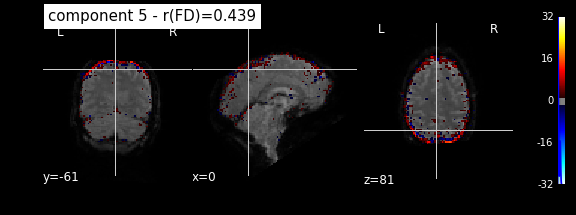

In [26]:
ica_motion_corr=numpy.zeros(ica_comps.shape[1])
for c in range(ica_comps.shape[1]):
    ica_motion_corr[c]=numpy.corrcoef(ica_comps[:,c],fd)[0,1]
    if abs(ica_motion_corr[c])>0.4:
        comp_img=nibabel.load(os.path.join(melodic_results.outputs.out_dir,'stats/thresh_zstat%d.nii.gz'%int(c+1)))
        nilearn.plotting.plot_stat_map(comp_img,mcflirt_results.outputs.mean_img,threshold=1.5,
               title='component %d - r(FD)=%0.3f'%(c+1,ica_motion_corr[c]))
        


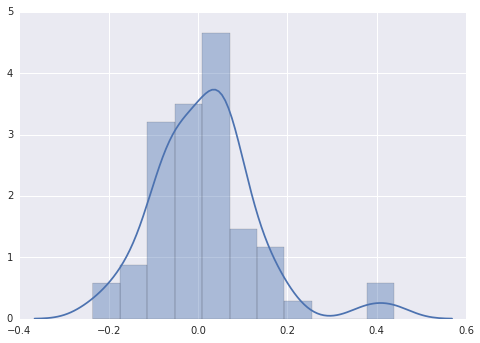

In [27]:
import seaborn as sns
sns.distplot(ica_motion_corr)

## Fieldmap unwarping

Take the first magnitue image and skull strip it

INFO:workflow:Executing node 8e99053e4a0a52d00606114ebae2c576 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/8e99053e4a0a52d00606114ebae2c576
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node 7415a968367307efda3766e1f8ceb869 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/7415a968367307efda3766e1f8ceb869
INFO:workflow:Collecting precomputed outputs


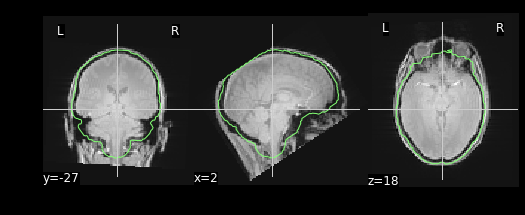

In [15]:
magfile=os.path.join(datadir,'ds031/sub00001',subject,
                'fieldmap/sub00001_ses014_001_magnitude.nii.gz')
roi = mem.cache(fsl.ExtractROI)
pick_first_mag = roi(in_file=magfile, t_min=0, t_size=1)

# we'll need this later
force_symlink(pick_first_mag.outputs.roi_file, os.path.join(results_dir, "fmapmag.nii.gz"))

mag_bet_results = bet(functional=True,
                      in_file=pick_first_mag.outputs.roi_file,
                      mask=True)
mag_bet_results.outputs
mask_display=nilearn.plotting.plot_epi(pick_first_mag.outputs.roi_file,cmap='gray')
mask_display.add_contours(mag_bet_results.outputs.mask_file, levels=[.5])

This was not quite tight enough. Let's try with other parameters

INFO:workflow:Executing node e435fff115deac37aa1dc7194389a041 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/e435fff115deac37aa1dc7194389a041
INFO:workflow:Collecting precomputed outputs



inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/e435fff115deac37aa1dc7194389a041/sub00001_ses014_001_magnitude_roi_brain_mask.nii.gz
meshfile = <undefined>
out_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-BET/e435fff115deac37aa1dc7194389a041/sub00001_ses014_001_magnitude_roi_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>

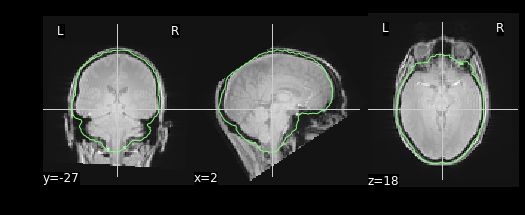

In [16]:
mag_bet_results = bet(functional=True,
                      in_file=pick_first_mag.outputs.roi_file,
                      mask=True,
                      frac=0.65)
force_symlink(mag_bet_results.outputs.out_file, os.path.join(results_dir, "fmapmagbrain.nii.gz"))
mask_display=nilearn.plotting.plot_epi(pick_first_mag.outputs.roi_file,cmap='gray')
mask_display.add_contours(mag_bet_results.outputs.mask_file, levels=[.5])
mag_bet_results.outputs

Prepare the fieldmap

In [17]:
prepare = mem.cache(fsl.PrepareFieldmap)
prepare_results = prepare(in_phase = os.path.join(datadir,'ds031/sub00001',subject,
                                                  'fieldmap/sub00001_ses014_001_phasediff.nii.gz'),
                          in_magnitude = mag_bet_results.outputs.out_file,
                          output_type = "NIFTI_GZ")
force_symlink(prepare_results.outputs.out_fieldmap, os.path.join(results_dir, "fieldmap.nii.gz"))
prepare_results.outputs

INFO:workflow:Executing node de872acb9153dcd09eb2450a3fd08f0e in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-epi-PrepareFieldmap/de872acb9153dcd09eb2450a3fd08f0e
INFO:workflow:Collecting precomputed outputs



out_fieldmap = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-epi-PrepareFieldmap/de872acb9153dcd09eb2450a3fd08f0e/sub00001_ses014_001_phasediff_fslprepared.nii.gz

Which parts of the brain were most deformed by B0 inhomogeneities?

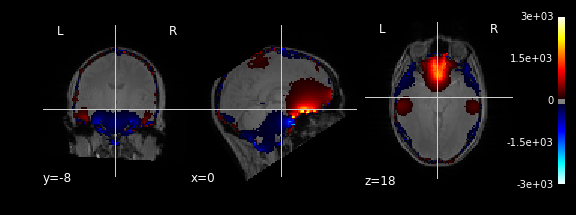

In [18]:
nilearn.plotting.plot_stat_map(nilearn.image.index_img(prepare_results.outputs.out_fieldmap,0), 
                               pick_first_mag.outputs.roi_file, threshold=100)

Note that we don't really apply these transformations yet. We'll do it after first level modelling

In [19]:
fugue = mem.cache(fsl.FUGUE)
fugue_results = fugue(in_file = mcflirt_results.outputs.mean_img,
                      fmap_in_file = prepare_results.outputs.out_fieldmap,
                      unwarp_direction = "y",
                      dwell_time = 2.6/10000.0,
                      mask_file = mag_bet_results.outputs.mask_file)
fugue_results.outputs

INFO:workflow:Executing node f33952ac5fe007779a55e37b747f71fd in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-FUGUE/f33952ac5fe007779a55e37b747f71fd
INFO:workflow:Collecting precomputed outputs



fmap_out_file = <undefined>
shift_out_file = <undefined>
unwarped_file = /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-FUGUE/f33952ac5fe007779a55e37b747f71fd/sub00001_ses014_task002_run001_bold_mcf.nii.gz_mean_reg_unwarped.nii.gz
warped_file = <undefined>

__Excersise:__ Plot the difference between the original mean EPI and the field unwarped one.

## Spatial smoothing

Perform spatial smoothing using Gaussian kernel. Can you spot the difference between top and bottom rows?

INFO:workflow:Executing node 61b7f927f50f1e2f1187e23ed0c9eb38 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-utils-Smooth/61b7f927f50f1e2f1187e23ed0c9eb38
INFO:workflow:Collecting precomputed outputs


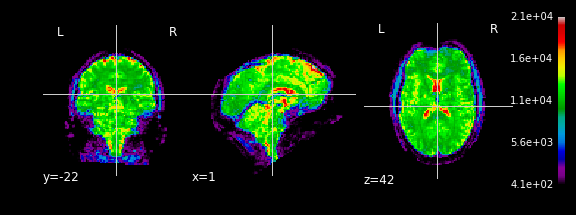

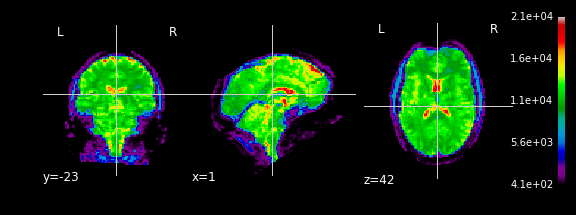

In [20]:
smooth = mem.cache(fsl.utils.Smooth)
smooth_results = smooth(fwhm=2.5,
                        in_file=mcflirt_results.outputs.out_file,
                        output_type = "NIFTI")

nilearn.plotting.plot_epi(mcflirt_results.outputs.mean_img,colorbar=True, vmin=410, vmax=21000)
nilearn.plotting.plot_epi(nilearn.image.mean_img(smooth_results.outputs.smoothed_file), colorbar=True, vmin=410, vmax=21000)

## High pass filtering

High-pass filtering - this will take a few minutes

In [21]:
hpfilt = mem.cache(fsl.maths.TemporalFilter)
TR = 2.32
hpfilt_results = hpfilt(highpass_sigma = 100/(2*TR),
                        in_file=smooth_results.outputs.smoothed_file,
                        output_type = "NIFTI")

mean = mem.cache(fsl.maths.MeanImage)
mean_results = mean(in_file = smooth_results.outputs.smoothed_file)

rescale = mem.cache(fsl.maths.BinaryMaths)
rescale_results = rescale(in_file=hpfilt_results.outputs.out_file,
                          operand_file = mean_results.outputs.out_file,
                          operation = "add",
                          output_type = "NIFTI")

force_symlink(rescale_results.outputs.out_file, os.path.join(results_dir, "preprocessed_epi_native_space.nii"))

INFO:workflow:Executing node f7ad533e4a31e1d4df6eae69ac95a245 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-maths-TemporalFilter/f7ad533e4a31e1d4df6eae69ac95a245
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node 73ff20dc51f2a3c5afc6b62dcc6b026c in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-maths-MeanImage/73ff20dc51f2a3c5afc6b62dcc6b026c
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node 8f2127a6d1564a45e01faaca63593d82 in dir: /home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-maths-BinaryMaths/8f2127a6d1564a45e01faaca63593d82
INFO:workflow:Collecting precomputed outputs


__Exercise:__ Plot the power spectrum for a voxel to look at the effects of filtering